In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Exercise 3.1

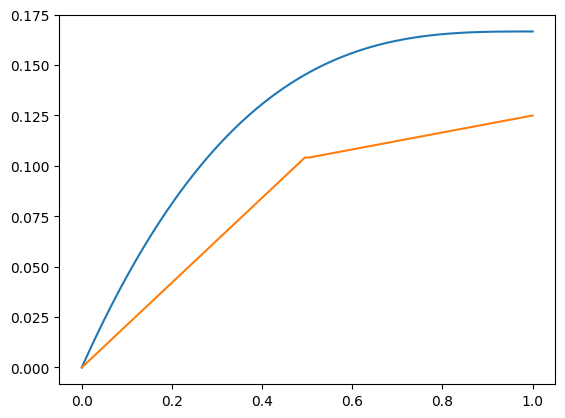

In [62]:
x = np.linspace(0,1,100)
x1 = np.linspace(0,0.5,50)
x2 = np.linspace(0.5,1,50)
z = np.zeros(50)
y = x*(x**2-3*x+3)/6


#N = [[1-x1,z],[2*x1,(2-2*x2)],[z,2*x2-1]]
Ns = [np.concatenate((1-x1,z), axis=0),np.concatenate((2*x1,(2-2*x2)), axis=0),np.concatenate((z,2*x2-1), axis=0)]
k = np.matrix([[-2,2,0],[2,0,2],[0,-2,2]])
f = np.array([5/24,1/4,1/24])
phi = np.linalg.solve(k,f)

phiT = np.zeros(100)

for i,v in enumerate(Ns):
    phiT += phi[i]*v


plt.plot(x,y)
plt.plot(x,phiT)
plt.show()


# Exercise 3.2

In [ ]:
def S(x):
    return 1-x

def stiffness(dx):
    return 1/dx*np.array([[1,-1],[-1,1]])

def force(dx,S):
    return ((dx)/6)*np.array([2*S(dx)+S(2*dx),S(dx)+2*S(2*dx)])

In [7]:
def solver(S,Ne,alpha,beta):
    # nodes = np.array([0, *sorted(np.random.rand(Ne-1)), 1])
    nodes=np.linspace(0,1,Ne+1)
    dx=nodes[1]-nodes[0]

    LM = np.zeros((2, Ne), dtype=np.int64)
    for e in range(Ne):
        if e==0:
            LM[0, e] = -1
            LM[1, e] = 0
        else:
            LM[0, e] = LM[1, e-1]
            LM[1, e] = LM[0, e] + 1

    K = np.zeros((Ne, Ne))
    F = np.zeros((Ne,))

    for e in range(Ne):
        k_e = stiffness(dx)
        
        for a in range(2):
            A = LM[a, e]
            f_e = force(dx,S)
            for b in range(2):
                B = LM[b, e]
                if (A >= 0) and (B >= 0):
                    K[A, B] += k_e[a, b]
            if (A >= 0):
                F[A] += f_e[a]
        # Modify force vector for Dirichlet BC
        if e == 0:
            F[0] -= alpha * k_e[1, 0]
    # Modify force vector for Neumann BC
    F[-1] += beta
    # Solve
    Psi_A = np.zeros_like(nodes)
    Psi_A[0] = alpha
    Psi_A[1:] = np.linalg.solve(K, F)

    return nodes, Psi_A

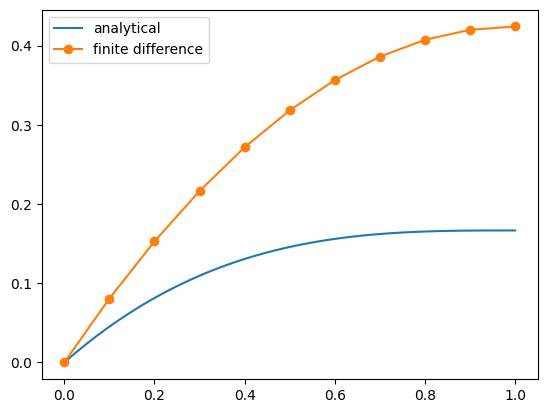

In [8]:
x_ana=np.linspace(0,1,100)
y_ana=x_ana*(x_ana**2-3*x_ana+3)/6 #x_ana*(4-6*x_ana+4*x_ana**2-x_ana**3)/12

alpha=0#.1
beta=0#-.2
Ne = 10
x,y=solver(S,Ne,alpha,beta)

plt.plot(x_ana,y_ana,label='analytical')
plt.plot(x,y,'o-',label='finite difference')
plt.legend()
plt.show()